In this notebook I collect some drinks data, explore the data and build a drink recommender based on their ingredients. <br>

Data source: www.drinksmixer.com

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import time
import csv
import re

## Data extraction

Get the recipes from www.drinksmixer.com

Get the recipes links first:

In [3]:
page_address = []
for i in range(1,9):
    page_address.append("http://www.drinksmixer.com/search/?q=cocktail&d=1&p=" + str(i))

list_1 = []

for i in range(8):   
    page = requests.get(page_address[i], time.sleep(.2))
    
    
#create beautiful soup object
    soup = bs(page.text, 'html.parser')


    for i in range(2):
        list_1.append(soup.find_all(class_= "l1a")[i].find_all("a"))

###flatten list_1
list_flat = [item for sublist in list_1 for item in sublist]


link_tails = []
for i in range(len(list_flat)):
        link_tails.append(list_flat[i]["href"])
        
        
### Now Build the recipe links ###

recipe_links = []
for i in range(len(link_tails)):
    recipe_links.append("http://www.drinksmixer.com" + link_tails[i]) 
    


In [4]:
recipe_links[0:10]

['http://www.drinksmixer.com/drink10391.html',
 'http://www.drinksmixer.com/drink7469.html',
 'http://www.drinksmixer.com/drink10313.html',
 'http://www.drinksmixer.com/drink8489.html',
 'http://www.drinksmixer.com/drink688.html',
 'http://www.drinksmixer.com/drink694.html',
 'http://www.drinksmixer.com/drink3411.html',
 'http://www.drinksmixer.com/drink740.html',
 'http://www.drinksmixer.com/drink746.html',
 'http://www.drinksmixer.com/drink750.html']

Now, get the recipes:

In [13]:
def extract(recipe_links):
    '''
    Given the recipe's links get the ingredients and ratings
    '''
    
    cocktail_rec = []
    for link in recipe_links:

        page = requests.get(link, time.sleep(0.2))

        soup = bs(page.text, 'html.parser')

        cocktail_name = soup.find(class_ = "fn recipe_title").string


        ing_name = soup.find(class_ = "ingredients").find_all(class_="name")
        ing_amount = soup.find(class_ = "ingredients").find_all(class_="amount")

        rating = soup.find(class_ = "ratingsBox rating").find("div",{"style":"font-size:36px; font-weight: bold;"})
        votes_num = soup.find(class_ = "ratingsBox rating").find("span",{"class":"count"})

        if rating != None:
            rating = rating.string
        if votes_num != None:
            votes_num = votes_num.string

        ingredients = [item.string for item in ing_name]

        cocktail_el = [cocktail_name, ingredients, rating, votes_num]
        cocktail_rec.append(cocktail_el)
        
    return cocktail_rec

## Data cleaning

cocktail_rec is now a nested list: [cocktail_name, [ingredients], rating, votes_num]. <br>

Total of 712 rec:

In [36]:
cocktail_rec = extract(recipe_links)

len(cocktail_rec)

712

In [43]:
def clean(cocktail_rec):
    
    '''
    some data cleaning and wrangling
    '''
    # connect the words in ingredients: we don't want to match "juice" with "juice"
    # orange juice --> orangejuice, lime juice -->limejuice
    try:
        for j in range(len(cocktail_rec)):
            for i in range(len(cocktail_rec[j][1])):
                cocktail_rec[j][1][i] = cocktail_rec[j][1][i].replace(" ","")
            
        # remove the words " Cocktail" and " recipe"
        for i in range(len(cocktail_rec)):
            cocktail_rec[i][0] = cocktail_rec[i][0].replace(" Cocktail","").replace(" recipe", "")
    
        # flatten the nested list
        for i in range(len(cocktail_rec)):
            rec=""
            for word in cocktail_rec[i][1]:
                rec = rec + word + " "
            cocktail_rec[i][1] = rec
    
    except:
        print("The list is already clean and flattened")
        
    return cocktail_rec


In [59]:
cocktail_rec = clean(cocktail_rec)

In [100]:
###  make a dataframe and save as cocktail_rec

recipe_df = pd.DataFrame(cocktail_rec , columns = ["Cocktail" , "Recipe", "Rating", "Number of Votes" ])

recipe_df.to_csv('./cocktail_rec.csv', index=False)

recipe_df.head()

,Cocktail,Recipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23
4,Abbey,gin orangebitters oranges cherry,9.0,21


## Some EDA

In [100]:
### read the recipe datafram
recipe_df = pd.read_csv('cocktail_rec.csv')

recipe_df.head()

,Cocktail,Recipe,Rating,Number of Votes
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27.0
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16.0
3,A1,gin GrandMarnier®orangeliqueur lemonjuice gren...,8.5,23.0
4,Abbey,gin orangebitters oranges cherry,9.0,21.0


In [18]:
## build a series of number of ingredients and add to recipe_df

recipe_df['Number of Ingredients']  = recipe_df['Recipe'].apply(lambda st : len(st.split()))
recipe_df.head(3)

,Cocktail,Recipe,Rating,Number of Votes,Number of Ingredients
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0,9
1,209 East,Sauza®HornitosReposadotequila Cointreau®orange...,7.4,27.0,4
2,352,151proofrum GreyGoose®vodka WildTurkey®bourbon...,7.0,16.0,3


In [19]:
## missing element ?

recipe_df.isnull().sum()

Cocktail                   0
Recipe                     0
Rating                   136
Number of Votes          136
Number of Ingredients      0
dtype: int64

In [20]:
recipe_df["Number of Ingredients"].value_counts()

4    246
3    228
5    121
2     49
6     47
7     15
9      3
8      3
Name: Number of Ingredients, dtype: int64

Text(0, 0.5, '')

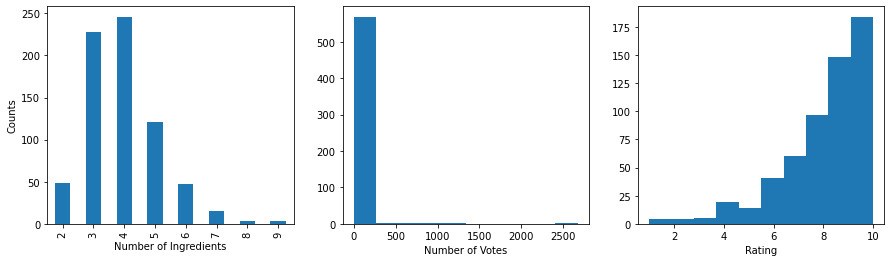

In [25]:
# see the distributions

fig, ax = plt.subplots(1,3, figsize=(15,4))
recipe_df["Number of Ingredients"].value_counts().sort_index().plot(kind="bar", ax=ax[0])
ax[0].set_xlabel("Number of Ingredients")
ax[0].set_ylabel("Counts")

recipe_df["Number of Votes"].plot.hist(ax=ax[1])
ax[1].set_xlabel("Number of Votes")
ax[1].set_ylabel("")


recipe_df["Rating"].plot.hist(ax=ax[2])
ax[2].set_xlabel("Rating")
ax[2].set_ylabel("")

In [14]:
# not_rated_df = recipe_df[recipe_df.isnull().any(axis=1)]
# not_rated_df.head(8)

### Look at drinks that have ratings

In [15]:
# build a new data frame by removing None values for rate 
recipe_df_rate = recipe_df.dropna()
recipe_df_rate["Rating"].describe()

count    576.000000
mean       8.031076
std        1.729918
min        1.000000
25%        7.175000
50%        8.500000
75%        9.300000
max       10.000000
Name: Rating, dtype: float64

In [101]:
# most used drinks (top 20)

recipe_df_rate.sort_values(by="Number of Votes", ascending=False).head(8)

,Cocktail,Recipe,Rating,Number of Votes,Number of Ingredients
170,Cosmopolitan,vodka triplesec Rose's®limejuice cranberryjuice,9.1,2673.0,4
432,Margarita,tequila triplesec limejuice,9.1,1120.0,3
690,Washington Apple,CrownRoyal®Canadianwhisky DeKuyper®SourApplePu...,9.6,918.0,3
431,Manhattan,sweetvermouth bourbonwhiskey Angostura®bitters...,9.5,717.0,5
438,Martini,gin dryvermouth,8.9,599.0,2
417,Long Island,tequila gin whiskey whiterum vodka sugarsyrup ...,9.6,442.0,8
487,Negroni,gin sweetvermouth Campari®bitters,9.6,311.0,3
57,Bellini,peachnectar lemonjuice peachschnapps Champagne...,9.5,230.0,5


In [17]:
## How many cocktails have a specific number of ingredients
## num_dict={num_of_ingridients: (rate<5, 5<rate<8, 8<rate<10)}

num_dict = {}
for ingr_num in recipe_df_rate['Number of Ingredients']:
    
    # number of cocktails with rating below 5
    num_of_cockt_5 = list(recipe_df_rate[recipe_df_rate['Rating']<=5]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 5 and 8
    num_of_cockt_8 = list(recipe_df_rate[(recipe_df_rate['Rating']<=8) & (recipe_df_rate['Rating']>5)]['Number of Ingredients']).count(ingr_num)
    # number of cocktails with rating between 8 and 10
    num_of_cockt_10 = list(recipe_df_rate[recipe_df_rate['Rating']>8]['Number of Ingredients']).count(ingr_num)
    
    num_dict[ingr_num] = (num_of_cockt_5, num_of_cockt_8, num_of_cockt_10) 
    
num_sorted = sorted(num_dict.items(), key=lambda x: x[0])

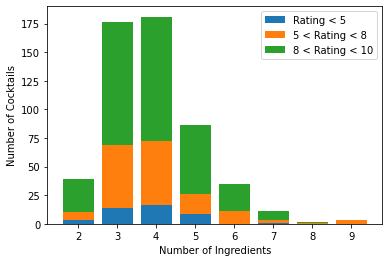

In [111]:
num_of_ingr = [ingr for ingr,count in num_sorted]

num_of_cockt_5 = [count[0] for ingr,count in num_sorted]
num_of_cockt_7 = [count[1] for ingr,count in num_sorted]
num_of_cockt_10 = [count[2] for ingr,count in num_sorted]


p1 = plt.bar(num_of_ingr, num_of_cockt_5, align='center')

p2 = plt.bar(num_of_ingr, num_of_cockt_7, bottom=num_of_cockt_5 , align='center')

p3 = plt.bar(num_of_ingr, num_of_cockt_10, bottom=num_of_cockt_7 , align='center')

plt.legend((p1,p2,p3),('Rating < 5','5 < Rating < 8 ','8 < Rating < 10'))

plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Cocktails')

plt.show()


In [112]:
recipe_df_rate["Number of Votes"].describe()

count     576.000000
mean       21.961806
std       135.104244
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max      2673.000000
Name: Number of Votes, dtype: float64

In [104]:
# Drinks with 7,8 and 9 ingredients sorted by number of votes

recipe_df_rate[(recipe_df_rate["Number of Ingredients"]>=7)].sort_values(by="Number of Votes",ascending=False).head(10)

,Cocktail,Recipe,Rating,Number of Votes,Number of Ingredients
417,Long Island,tequila gin whiskey whiterum vodka sugarsyrup ...,9.6,442.0,8
291,Fruit,orangejuice grapefruitjuice passion-fruitjuice...,8.6,221.0,7
416,Long Beach,tequila triplesec rum vodka gin sweetandsourmi...,9.3,114.0,7
0,187,RedRum®rum 99Bananas®bananaschnapps strawberry...,7.8,47.0,9
606,Sazerac,sugar ryewhiskey Deva®absinthe Peychaud®bitter...,9.5,34.0,7
292,Fruit #2,Absolut®Mandrinvodka CaptainMorgan®ParrotBaypi...,9.3,15.0,7
317,H-Bomb,vodka tequila rum gin triplesec sweetandsourmi...,9.5,15.0,7
640,Stoli Fruit,Stoli®Ohranjvodka Stoli®Razberivodka Stoli®Str...,7.1,9.0,9
353,Iced Tea,darkrum brandy triplesec orangejuice limejuice...,7.4,7.0,7
565,Purple,SouthernComfort®peachliqueur BlueCuracaoliqueu...,5.5,4.0,7


## <font color='blue'> Recommendation system for the original data frame </font>

In [52]:
###  Find the count matrix

count_vec = CountVectorizer() 
feature_vec = count_vec.fit_transform(recipe_df["Recipe"])


### generating the cosine similarity matrix

cos_sim = cosine_similarity(feature_vec, feature_vec)

cos_sim_df = pd.DataFrame(cos_sim )


### find the count vector 
# vocab_vec = count_vec.fit_transform(recipe_df["Recipe"])



In [53]:
cos_sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,702,703,704,705,706,707,708,709,710,711
0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.117851,0.166667,...,0.129099,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.0
1,0.0,1.000000,0.0,0.169031,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.169031,0.0,1.000000,0.223607,0.0,0.258199,0.000000,0.000000,0.258199,...,0.200000,0.316228,0.200000,0.0,0.365148,0.258199,0.000000,0.258199,0.223607,0.0
4,0.0,0.000000,0.0,0.223607,1.000000,0.0,0.288675,0.288675,0.000000,0.000000,...,0.000000,0.353553,0.223607,0.0,0.204124,0.288675,0.353553,0.000000,0.250000,0.0


In [99]:
### The most used ingredients (Top 10)

pd.DataFrame(list(zip(count_vec.get_feature_names(),np.asarray(feature_vec.sum(axis=0))[0])), columns=['drink','count']).sort_values(by="count", ascending=False).iloc[0:10]

,drink,count
167,gin,214
143,dryvermouth,122
226,lemonjuice,108
45,bitters,98
401,triplesec,93
185,grenadinesyrup,91
407,vodka,88
390,sweetvermouth,85
285,orangejuice,83
237,limejuice,74


In [120]:
## A function to show the common ingredients between two cocktails

def common_ingredients(coct1,coct2):
    index1  = recipe_df[recipe_df["Cocktail"]==coct1].index[0]
    index2  = recipe_df[recipe_df["Cocktail"]==coct2].index[0]
    
    recipe1 = recipe_df.iloc[index1]["Recipe"].split()
    recipe2 = recipe_df.iloc[index2]["Recipe"].split()
    
    common_ingr = []
    for ingredient in recipe1:
        if ingredient in recipe2:
            common_ingr.append(ingredient)
            
    return common_ingr

In [121]:
# a function to return the ingredients
def ingredients(cocktail):
    ing = recipe_df[recipe_df["Cocktail"]==cocktail]["Recipe"].values[0].split()
    return ing

In [122]:
common_ingredients("Abbey","Bijou")

['gin', 'orangebitters', 'cherry']

In [123]:
###  Build a function that gives the n best matches to two chosen cocktails ###

def cocktail_recommender2(cocktail1, cocktail2):
    coct1 = cocktail1
    coct2 = cocktail2
    ind1  = recipe_df[recipe_df["Cocktail"]==coct1].index[0]
    ind2  = recipe_df[recipe_df["Cocktail"]==coct2].index[0]

    score1 = pd.Series(cos_sim_df[ind1]).drop(labels=[ind1,ind2])    
    score2 = pd.Series(cos_sim_df[ind2]).drop(labels=[ind1,ind2])
    
    score = (score1+score2)/2
    score = score.sort_values(ascending= False)
    

    ## top 5 elements
    best_match_ind = list(score.head(5).index)



    ## add same scores as 5th cocktail in the list
    for i in range(5,712):
        if score.iloc[i+1]==score.iloc[i]:
            best_match_ind.append(list(score.iloc[i+1:i+2].index)[0])
        else:
            break
    
    
    ## make the list of at least top 5 matches     
    best_match=[]
    for i in best_match_ind:
        best_match.append(recipe_df.iloc[i][0])
        
    
        
    joint = ", "
    line = "_"*100
    print(f"If you are a fan of \"{coct1}\" and \"{coct2}\", you should also try {joint.join(best_match)}.\n{line}")
    
    coct1_ing = recipe_df.iloc[ind1]["Recipe"].split()
    coct2_ing = recipe_df.iloc[ind2]["Recipe"].split()

#     print(f"{coct1} Ingredients are: {coct1_ing}")
#     print("-"*100)
#     print(f"{coct2} Ingredients are: {coct2_ing}")

#     print("\n")
    
#     for match in best_match:
#         extra_ing = [ing for ing in ingredients(match) if ing not in ingredients(coct)]
        
#         print(f"Common Ingredients with {match}: {common_ingredients(coct,match)}, Extra Ingredients: {extra_ing}")
#         print("_"*100)
        
#         '''
    

In [124]:
cocktail_recommender2("Abbey", "Southern Gin")

If you are a fan of "Abbey" and "Southern Gin", you should also try Opal, Tailspin, Crystal Slipper, Hi Ho, Jewel, Bijou, Alaska.
____________________________________________________________________________________________________


In [125]:
###  Build a function that gives the n best matches to a chosen cocktail ###

def cocktail_recommender(cocktail_name):
    coct = cocktail_name
    ind  = recipe_df[recipe_df["Cocktail"]==coct].index[0]

    score = pd.Series(cos_sim_df[ind]).sort_values(ascending= False)

    ## ignore the score of the first index which is 1, corresponds to "coct" itself
    best_match_ind = list(score.iloc[1:6].index)



    ## add same scores as 5th cocktail in the list
    for i in range(5,712):
        if score.iloc[i+1]==score.iloc[i]:
            best_match_ind.append(list(score.iloc[i+1:i+2].index)[0])
        else:
            break
    
    
    ## make the list of at least top 5 matches     
    best_match=[]
    for i in best_match_ind:
        best_match.append(recipe_df.iloc[i][0])
        
    
        
    joint = ", "
    line = "-"*100
    print(f"If you are a fan of \"{coct}\", you should also try {joint.join(best_match)}.\n{line}")
    
    coct_ing = recipe_df.iloc[ind]["Recipe"].split()
    print(f"\"{coct}\" Ingredients are: {coct_ing}")
    print("\n")
    
    for match in best_match:
        extra_ing = [ing for ing in ingredients(match) if ing not in ingredients(coct)]
        
        print(f"Common Ingredients with \"{match}\": {common_ingredients(coct,match)}, Extra Ingredients: {extra_ing}")
        print("_"*100)
        

## See how the recommender works:

In [126]:
cocktail_recommender("Negroni")

If you are a fan of "Negroni", you should also try Caricature, Perfect, Fernet Branca, Farmer's, Dry Negroni.
----------------------------------------------------------------------------------------------------
"Negroni" Ingredients are: ['gin', 'sweetvermouth', 'Campari®bitters']


Common Ingredients with "Caricature": ['gin', 'sweetvermouth', 'Campari®bitters'], Extra Ingredients: ['grapefruitjuice', 'simplesyrup']
____________________________________________________________________________________________________
Common Ingredients with "Perfect": ['gin', 'sweetvermouth'], Extra Ingredients: ['dryvermouth', 'bitters']
____________________________________________________________________________________________________
Common Ingredients with "Fernet Branca": ['gin', 'sweetvermouth'], Extra Ingredients: ['FernetBranca®bitters']
____________________________________________________________________________________________________
Common Ingredients with "Farmer's": ['gin', 'sweetvermouth